# Devlog 2023-07-13

Now that we have done a compatibility pass with all of the system modules, let's do a compatibility test. The results of this test should comport with [the analysis in this spreadsheet](https://docs.google.com/spreadsheets/d/1FF_ovXYQUb65JagcLj8QCmCzs2_Pzd9qnZ5Cr28v4jw/edit?usp=sharing).

Generate the cross product of all available modules and test them one-by-one to see if they run successfully. We'll just run each simulation for a few days and verify that this doesn't throw any exceptions. Ideally, these results will line up with our expected compatibility matrix.

In [1]:
from datetime import date
import time
from epymorph.data import mm_library, geo_library, ipm_library
from itertools import product
import pandas as pd
from epymorph.movement.hypercube import HypercubeEngine

from epymorph.simulation import Simulation

geo_order = ['pei', 'single_pop', 'us_counties_2015',
             'us_states_2015', 'maricopa_cbg_2019']
mm_order = ['pei', 'sparsemod', 'centroids', 'icecube', 'no']
ipm_order = ['pei', 'sirs', 'sirh', 'no']

# geo_order = ['pei', 'single_pop']
# mm_order = ['pei', 'sparsemod']
# ipm_order = ['pei', 'simple_sirs']

combos = pd.DataFrame(
    product(geo_order, mm_order, ipm_order),
    columns=['geo', 'mm', 'ipm']
)

# Params to satisfy every combo!
params = {
    'alpha': [0.05, 0.4125, 0.5875],
    'beta': 0.4,
    'gamma': 0.1000022,
    'xi': 1 / 90.0,
    'phi': 40,
    'theta': 0.1,
    'move_control': 0.9,
    'infection_duration': 4.0,
    'immunity_duration': 90.0,
    'hospitalization_duration': 14.0,
    'hospitalization_rate': 0.1,
    'infection_seed_loc': 0,
    'infection_seed_size': 100
}


def test(geo, mm, ipm):
    success = True
    t0 = time.perf_counter()
    try:
        Simulation(
            geo=geo_library[geo](),
            ipm_builder=ipm_library[ipm](),
            mvm_builder=mm_library[mm](),
            mvm_engine=HypercubeEngine
        ).run(params, date(2010, 1, 1), 3)
    except:
        success = False
    t1 = time.perf_counter()
    print(f"{'succeeded' if success else 'failed'}: {geo, mm, ipm} in {((t1 - t0) * 1000.0):.3f} ms")
    return pd.Series([success, t1 - t0])


compat = combos.copy()
compat[['runs', 'runtime']] = combos.apply(
    lambda x: test(x['geo'], x['mm'], x['ipm']),
    axis=1)


succeeded: ('pei', 'pei', 'pei') in 51.883 ms
succeeded: ('pei', 'pei', 'sirs') in 18.741 ms
succeeded: ('pei', 'pei', 'sirh') in 158.399 ms
succeeded: ('pei', 'pei', 'no') in 9.560 ms
succeeded: ('pei', 'sparsemod', 'pei') in 16.422 ms
succeeded: ('pei', 'sparsemod', 'sirs') in 14.356 ms
succeeded: ('pei', 'sparsemod', 'sirh') in 23.009 ms
succeeded: ('pei', 'sparsemod', 'no') in 6.520 ms
succeeded: ('pei', 'centroids', 'pei') in 14.976 ms
succeeded: ('pei', 'centroids', 'sirs') in 13.567 ms
succeeded: ('pei', 'centroids', 'sirh') in 22.233 ms
succeeded: ('pei', 'centroids', 'no') in 5.783 ms
succeeded: ('pei', 'icecube', 'pei') in 14.602 ms
succeeded: ('pei', 'icecube', 'sirs') in 13.692 ms
succeeded: ('pei', 'icecube', 'sirh') in 21.667 ms
succeeded: ('pei', 'icecube', 'no') in 5.482 ms
succeeded: ('pei', 'no', 'pei') in 13.492 ms
succeeded: ('pei', 'no', 'sirs') in 10.497 ms
succeeded: ('pei', 'no', 'sirh') in 17.635 ms
succeeded: ('pei', 'no', 'no') in 4.798 ms
failed: ('single_po

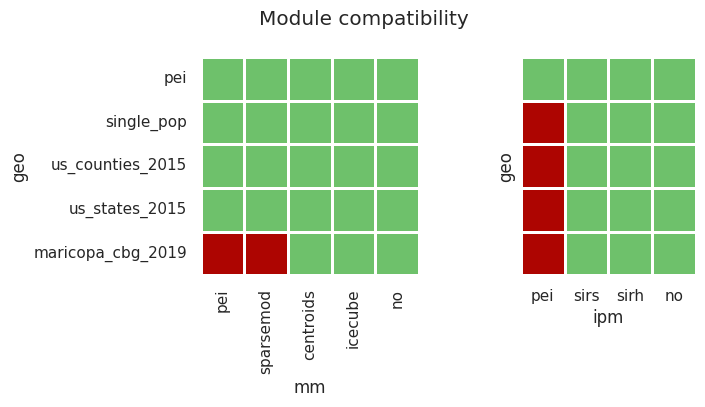

In [2]:
from functools import partial, reduce
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

boolean_or = partial(reduce, bool.__or__)


mm_compat = compat.groupby(by=['geo', 'mm'])\
    .agg({'runs': boolean_or})\
    .reset_index()\
    .pivot(index='geo', columns='mm', values='runs')\
    .reset_index()\
    .reindex(columns=['geo', *mm_order])\
    .sort_values(by='geo', key=lambda x: x.map({k: v for v, k in enumerate(geo_order)}))\
    .set_index('geo')

# display(mm_compat)


ipm_compat = compat.groupby(by=['geo', 'ipm'])\
    .agg({'runs': boolean_or})\
    .reset_index()\
    .pivot(index='geo', columns='ipm', values='runs')\
    .reset_index()\
    .reindex(columns=['geo', *ipm_order])\
    .sort_values(by='geo', key=lambda x: x.map({k: v for v, k in enumerate(geo_order)}))\
    .set_index('geo')

# display(ipm_compat)

palette = ['#AD0501', '#6EC16B']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

sns.heatmap(mm_compat,
            cmap=palette,
            cbar=False,
            square=True,
            linewidths=1,
            ax=ax1)

sns.heatmap(ipm_compat,
            cmap=palette,
            cbar=False,
            square=True,
            linewidths=1,
            ax=ax2)

plt.suptitle("Module compatibility")
plt.tight_layout()
plt.show()

# NOTE: and when I ran this, it matched my expectations as laid out in this spreadsheet:
# https://docs.google.com/spreadsheets/d/1FF_ovXYQUb65JagcLj8QCmCzs2_Pzd9qnZ5Cr28v4jw/edit?usp=sharing


In [3]:
# What are the slowest sims (that succeed)?
compat\
    .loc[compat['runs'] == True]\
    .sort_values(by='runtime', ascending=False)\
    .reset_index(drop=True)


,geo,mm,ipm,runs,runtime
0,us_counties_2015,no,sirh,True,12.792170
1,us_counties_2015,no,sirs,True,12.576295
2,us_counties_2015,no,no,True,11.225714
3,us_counties_2015,pei,sirh,True,9.630683
4,us_counties_2015,sparsemod,sirh,True,8.885492
...,...,...,...,...,...
69,pei,no,no,True,0.004798
70,single_pop,sparsemod,no,True,0.003482
71,single_pop,centroids,no,True,0.003280
72,single_pop,icecube,no,True,0.002694
